# **TRABAJO FINAL-APRENDIZAJE AUTOMÁTICO**
Francisco Galiano  
Daniela Correa


#Sistema automático para la detección de COVID-19 en radiografías#



Una de las aplicaciones de AI es el procesamiendo de imágenes médicas. En particular, el uso de radiografías para una detección no invasiva y rápida del Covid-19 puede resultar extremadamente útil para ayudar y agilizar la tarea del personal médico [1][2].

En este proyecto desarrollaremos un detector *Deep Learning* de Covid-19 en radiografías. Para ello, utilizaremos las imágeners de la base de datos "Covid-chestxray-dataset" [3], generada por unos investigadores del grupo de investigación [Mila](https://mila.quebec/en/) y de la Universidad de Montreal [4]. También utilizaremos imágenes de radiografías de pacientes sanos y con neumonía bacterial extraídas de la competición de Kaggle "Chest X-Ray Images (Pneumonia)" [5].

En total, disponemos de una cantidad de 426 imágenes, divididas en conjuntos de entrenamiento (339 imágenes), validación (42 imágenes) y test (45 imágenes).

Las particiones se dan en listas ".txt", en las que a cada imagen se le asigna una etiqueta:
- 0) Healthy
- 1) Covid-19
- 2) Pneumonia

El objetivo consisten en desarrollar un sistema basado en redes neuronales capaz de clasificar correctamente las imágenes en estas 3 categorías.


#### Referencias
1. María Climent, 2020 [Covid-19: La Inteligencia Artificial De La Española Quibim Puede Acelerar El Diagnóstico Del Coronavirus](https://innovadores.larazon.es/es/esta-inteligencia-artificial-espanola-puede-acelerar-el-diagnostico-del-coronavirus/)
2. Angel Alberich-bayarri,2020 [Imagin, AI and Radiomix to understand and fight Coronavirus Covid-19](https://quibim.com/2020/02/14/imaging-ai-and-radiomics-to-understand-and-fight-coronavirus-covid-19/)
3. [Ieee8023/covid-chestxray-dataset](https://github.com/ieee8023/covid-chestxray-dataset)
4. Cohen, J.P., Morrison, P. and Dao, L., 2020. [COVID-19 image data collection](https://arxiv.org/pdf/2003.11597.pdf).
5. Paul Mooney, 2019 [Chest X-ray Images (pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)


#### Lecturas recomendadas
6. Souradip Chakraborty, 2020. [Detection Of Covid-19 Presence from Chest X-ray Scans Using Cnn & Class Activation Maps](https://towardsdatascience.com/detection-of-covid-19-presence-from-chest-x-ray-scans-using-cnn-class-activation-maps-c1ab0d7c294b)

7. Cohen, J.P., Hashir, M., Brooks, R. and Bertrand, H., 2020. [On the limits of cross-domain generalization in automated X-ray prediction](https://arxiv.org/pdf/2002.02497.pdf)

8. Karim, M., Döhmen, T., Rebholz-Schuhmann, D., Decker, S., Cochez, M. and Beyan, O., 2020. [Deepcovidexplainer: Explainable covid-19 predictions based on chest x-ray images](https://arxiv.org/pdf/2004.04582.pdf).

9. Wang, L., Wong, A. (2020). [COVID-Net: A Tailored Deep Convolutional Neural Network Design for Detection of COVID-19 Cases from Chest Radiography Images](https://arxiv.org/abs/2003.09871)

10. Zhou, B., Khosla, A., Lapedriza, A., Oliva, A. and Torralba, A., 2016. [Learning deep features for discriminative localization](https://arxiv.org/pdf/1512.04150.pdf). In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2921-2929).

11. Mordvintsev, A., Olah, C. and Tyka, M., 2015. [Inceptionism: Going deeper into neural networks](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html).

In [136]:
#librerías
from google.colab import drive
import pandas as pd
import os
import tensorflow as tf #TensorFlow y Keras se usarán para manejar el procesamiento de imágenes y el modelo.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report # Matriz de confusión
import seaborn as sns
import gradio as gr
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image


In [92]:
#Conectamos el drive con el colab
drive.mount('/content/drive')

# Definimos la ruta donde estan todos nuestros datos para trabajar
data_path = '/content/drive/MyDrive/Datos trabajo final/data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preparación del Dataset

En este primer apartado se analizarán las imágenes de la base de datos y se diseñará un *pipeline* para cargar las imágenes y prepararlas para la red neuronal.

Se deberán tener en cuenta factores como:
- Tamaño de entrada de las imágenes
- Normalización de las imágenes
- Visualizaciones de algunas muestras de cada categoría
- Técnicas de *data augmentation* para aumentar el tamaño del conjunto de entrenamiento

Y, en general, cualquier técnica que consideréis que pueda mejorar la implementación y resultados de este proyecto.

Comenzamos estructurando los datos a la hora de cargarlos

In [94]:
#Creamos rutas completas para los archivos de entrenamiento, validación y prueba.
train_file = os.path.join(data_path, "training.txt")
val_file = os.path.join(data_path, "validation.txt")
test_file = os.path.join(data_path, "testing.txt")

#Cargamos los archivos .txt en DataFrames de pandas. Cada archivo contiene una etiqueta (label) y la ruta de la imagen (path).
columns = ["label", "path"]
train_df = pd.read_csv(train_file, delim_whitespace=True, header=None, names=columns)
val_df = pd.read_csv(val_file, delim_whitespace=True, header=None, names=columns)
test_df = pd.read_csv(test_file, delim_whitespace=True, header=None, names=columns)

#Imprimimos df
print("Training Set:")
print(train_df.head(50))
print("\nValidation Set:")
print(val_df.head(50))
print("\nTesting Set:")
print(test_df.head(50))


Training Set:
    label                                     path
0       2   PNEUMONIA/person888_bacteria_2812.jpeg
1       2  PNEUMONIA/person1209_bacteria_3161.jpeg
2       2  PNEUMONIA/person1718_bacteria_4540.jpeg
3       2   PNEUMONIA/person549_bacteria_2303.jpeg
4       2   PNEUMONIA/person831_bacteria_2742.jpeg
5       2  PNEUMONIA/person1571_bacteria_4108.jpeg
6       2  PNEUMONIA/person1310_bacteria_3300.jpeg
7       2   PNEUMONIA/person315_bacteria_1465.jpeg
8       2   PNEUMONIA/person441_bacteria_1917.jpeg
9       2  PNEUMONIA/person1276_bacteria_3239.jpeg
10      2  PNEUMONIA/person1761_bacteria_4603.jpeg
11      2      PNEUMONIA/person23_bacteria_82.jpeg
12      2   PNEUMONIA/person339_bacteria_1572.jpeg
13      2   PNEUMONIA/person412_bacteria_1827.jpeg
14      2  PNEUMONIA/person1590_bacteria_4174.jpeg
15      2   PNEUMONIA/person640_bacteria_2532.jpeg
16      2   PNEUMONIA/person508_bacteria_2144.jpeg
17      2     PNEUMONIA/person67_bacteria_328.jpeg
18      2   PNEUM

<ipython-input-94-c67606907321>:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_df = pd.read_csv(train_file, delim_whitespace=True, header=None, names=columns)
<ipython-input-94-c67606907321>:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  val_df = pd.read_csv(val_file, delim_whitespace=True, header=None, names=columns)
<ipython-input-94-c67606907321>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_df = pd.read_csv(test_file, delim_whitespace=True, header=None, names=columns)


*El conjunto de datos tiene etiquetas para las tres clases, así el modelo puede diferenciar las imágenes*

In [95]:
print("Distribución en Training Set:")
print(train_df['label'].value_counts())


Distribución en Training Set:
label
2    113
1    113
0    113
Name: count, dtype: int64


*Todas las clases tienen el mismo número de imágenes (113), lo cual es ideal para evitar que el modelo tenga sesgo hacia una clase en particular.*

*Aunque está balanceado, el tamaño total de las imágenes (339) sigue siendo limitado, para solucionarlo, luego aplicaremos data augmentation. Esto podría dificultar que el modelo generalice bien, especialmente si las imágenes son complejas o las diferencias entre clases son sutiles (como en radiografías).*

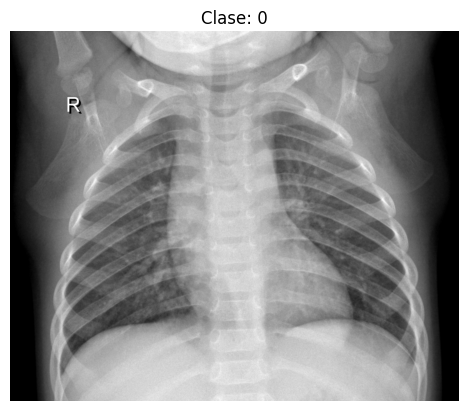

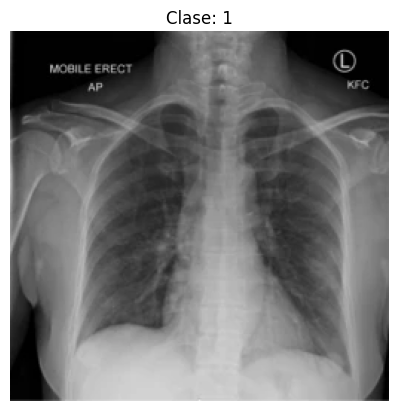

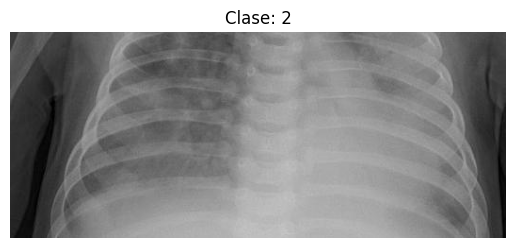

In [96]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

for label in [0, 1, 2]:
    img_path = os.path.join(data_path, train_df[train_df['label'] == label].iloc[0]['path'])
    img = load_img(img_path)
    plt.imshow(img, cmap='gray')
    plt.title(f"Clase: {label}")
    plt.axis("off")
    plt.show()


*Tenemos una radiografia de cada en el que la clase 0 es HEALTHY, la clase 1 es COVID, la clase 2 es PNEUMONÍA*

In [97]:
# Parámetros de configuración
IMG_SIZE = 224  # Tamaño al que redimensionaremos las imágenes
BATCH_SIZE = 32  # Tamaño de lote para entrenamiento y validación.

#Esta función carga imágenes y las preprocesa para su uso en el modelo.
def load_and_preprocess_data(df, data_path):
    images = []
    labels = []
    for _, row in df.iterrows(): #Iteramos por cada fila del DataFrame
        img_path = os.path.join(data_path, row["path"]) #Obtenemos la ruta completa de la imagen
        label = row["label"] #Obtenemos la etiqueta correspondiente

        #Cargamos imagen
        img = tf.keras.utils.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE)) # Redimensionar la imagen
        img = tf.keras.utils.img_to_array(img) / 255.0  #Convertir a array y normalizar a rango [0, 1]

        #Añadir imagen y etiqueta a las listas
        images.append(img)
        labels.append(label)
    # Convertir listas a arrays numpy y transformar etiquetas a formato one-hot
    return np.array(images), to_categorical(labels, num_classes=3)

#Cargar y preprocesar los datos
#Usamos la función definida para preparar los conjuntos de entrenamiento, validación y prueba.
train_images, train_labels = load_and_preprocess_data(train_df, data_path)
val_images, val_labels = load_and_preprocess_data(val_df, data_path)
test_images, test_labels = load_and_preprocess_data(test_df, data_path)

#Imprimir formas para confirmar
#Verificamos que los datos se hayan cargado correctamente mostrando las dimensiones de las imágenes y etiquetas.
print("Training data shape:", train_images.shape, train_labels.shape)
print("Validation data shape:", val_images.shape, val_labels.shape)
print("Testing data shape:", test_images.shape, test_labels.shape)



Training data shape: (339, 224, 224, 3) (339, 3)
Validation data shape: (42, 224, 224, 3) (42, 3)
Testing data shape: (45, 224, 224, 3) (45, 3)


**Training data shape: (339, 224, 224, 3):**

*   339 imágenes de entrenamiento, todas redimensionadas a 224x224 píxeles con 3 canales (RGB).


**Validation data shape: (42, 224, 224, 3):**

*   42 imágenes de validación con las mismas dimensiones.



**Testing data shape: (45, 224, 224, 3):**

*   45 imágenes de prueba con las mismas dimensiones.



Como tenemos pocos datos, vamos a hacer un data augmentation para obtener mas datos a partir de los que ya tenemos mediante pequeñas rotaciones

In [111]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Crear un generador de data augmentation para entrenamiento
train_datagen = ImageDataGenerator(
    rotation_range=20,          # Rotación aleatoria en grados
    width_shift_range=0.2,      # Desplazamiento horizontal
    height_shift_range=0.2,     # Desplazamiento vertical
    shear_range=0.2,            # Transformación en corte
    zoom_range=0.2,             # Zoom aleatorio
    horizontal_flip=True,       # Volteo horizontal
    fill_mode='nearest'         # Cómo rellenar los píxeles vacíos
)

# Crear un generador sin augmentación para validación
val_datagen = ImageDataGenerator()

# Crear generadores para entrenamiento y validación
train_generator = train_datagen.flow(
    train_images, train_labels,  # Datos de entrada y etiquetas para entrenamiento
    batch_size=32               # Tamaño del batch
)

val_generator = val_datagen.flow(
    val_images, val_labels,      # Datos de entrada y etiquetas para validación
    batch_size=32
)

Ejemplos de Data Augmentation:


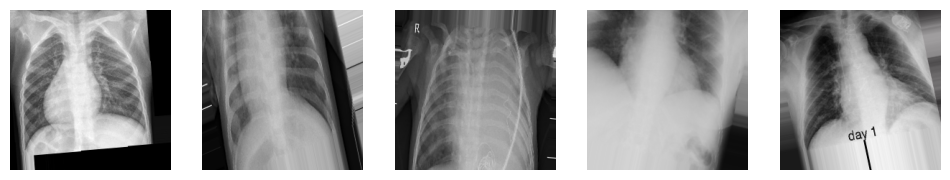

In [112]:
# Visualizar ejemplos de data augmentation
def visualize_augmentation(generator, num_images=5):
    """
    Muestra ejemplos de imágenes aumentadas generadas por el generador.
    """
    augmented_images, _ = next(generator)  # Obtener un batch de imágenes aumentadas
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(augmented_images[i])
        plt.axis('off')
    plt.show()

# Visualizar algunas imágenes aumentadas
print("Ejemplos de Data Augmentation:")
visualize_augmentation(train_generator)


# Creación del modelo y métricas de evaluación

En esta sección se tiene que desarrollar el *pipeline* para la creación y entrenamiento de el/los modelo/s.

Se trabajará con los datos de *training* y de *validación*.

Se deberán tener en cuenta aspectos como:
- El tipo de arquitectura más adecuado para el problema
- Las métricas que se deben utilizar para medir de forma correcta el comportamiento del modelo
- Visualizaciones de las curvas de entrenamiento/validación que ayuden a decidir cuál ha sido el mejor modelo.
- Considerar un modelo *baseline* para poder comparar las métricas (por ejemplo, utilizar predicciones aleatorias o utilizar un modelo muy sencillo, como por ejemplo una red con muy pocas capas)


## MODELO CNN

Empezamos definiendo la arquitectura del modelo que vamos a desarrollar, durante todo el codigo cuando nos referimos al **modelo inicial**, estamos refiriendonos a este, al mas complejo, mas adelante creamos otro mas sencillo para compararlo, y a ese nos hacemos referencia como, **modelo basico**

In [113]:
# Definir el modelo CNN
def create_cnn_model():
    model = Sequential([ # Usamos el modelo secuencial para construir la CNN capa por capa
        # Primera capa convolucional + max pooling
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        # Aplica 32 filtros de tamaño 3x3 y usa la función de activación ReLU.
        MaxPooling2D(pool_size=(2, 2)), #Reduce la dimensionalidad usando un pool de 2x2.

        # Segunda capa convolucional + max pooling
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Tercera capa convolucional + max pooling
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(), #Aplana las características extraídas en un vector 1D.
        Dense(128, activation='relu'), # Capa completamente conectada con 128 neuronas.
        Dropout(0.5),  # Regularización para prevenir sobreajuste.
        Dense(3, activation='softmax')  # Capa de salida con 3 neuronas (una por clase) y softmax para clasificación multiclase.
    ])

    #Configuramos el modelo con el optimizador Adam, la función de pérdida para clasificación categórica y la métrica de precisión.
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = create_cnn_model()

# Resumen del modelo
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Elegimos el **modelo secuencial** porque es fácil de construir capa por capa. Incluimos **capas convolucionales** para extraer características de las imágenes, con filtros crecientes (32, 64, 128) para captar detalles simples y complejos. Usamos **MaxPooling** para reducir la dimensionalidad, **Flatten** para conectar con capas densas, y **Dropout** para evitar el sobreajuste. La capa final con la función de activación **softmax** clasifica en 3 categorías. Hemos considerado esta arquitectura la más óptima para trabajar con radiografías

***Vamos a implementar early-stopping para que el modelo pare cuando ya no haya mejores, para evitar el sobreajuste***

In [115]:
# Configuración de Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorea la pérdida en validación
    patience=3,          # Si la pérdida no mejora después de 3 épocas consecutivas, el entrenamiento se detendrá.
    restore_best_weights=True,  #Una vez detenido el entrenamiento, se restauran los pesos del modelo con el mejor desempeño en validación.
    verbose=1
)

# Entrenaremos el modelo con la implementación de Early Stopping
history = model.fit(
    train_generator, #Conjunto de entrenamiento (imágenes y etiquetas).
    validation_data=val_generator,#Conjunto de validación para evaluar el modelo en cada época.
    epochs=20,  # Número máximo de épocas
    callbacks=[early_stopping]#se para cuando el modelo no mejora para evitar el sobreentrenamiento.

)



Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.3568 - loss: 1.4471 - val_accuracy: 0.3810 - val_loss: 1.0482
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.5380 - loss: 0.9996 - val_accuracy: 0.6905 - val_loss: 0.7671
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.6844 - loss: 0.7667 - val_accuracy: 0.6667 - val_loss: 0.7918
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.7256 - loss: 0.7186 - val_accuracy: 0.5952 - val_loss: 0.7782
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 74s 4s/step - accuracy: 0.7124 - loss: 0.6709 - val_accuracy: 0.8095 - val_loss: 0.4656
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.7750 - loss: 0.5446 - val_accuracy: 0.9048 - val_loss: 0.4492
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.8014 - loss: 0.5953 - val_accuracy: 0.9048 - val_loss: 0.3735
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.8334 - loss: 0.4436 - val_accuracy: 0.8333 - val_loss: 0.3412
Epo

*Contemplamos que se ha terminado en la época 12 con estos resultados: -accuracy: 0.8074 - loss: 0.4706 - val_accuracy: 0.8571 - val_loss: 0.3523.  
 Según early stopping considera que la época 12 es el pick del entrenamiento, a partir de las siguientes epocas el modelo empezaría a sobre entrenarse*

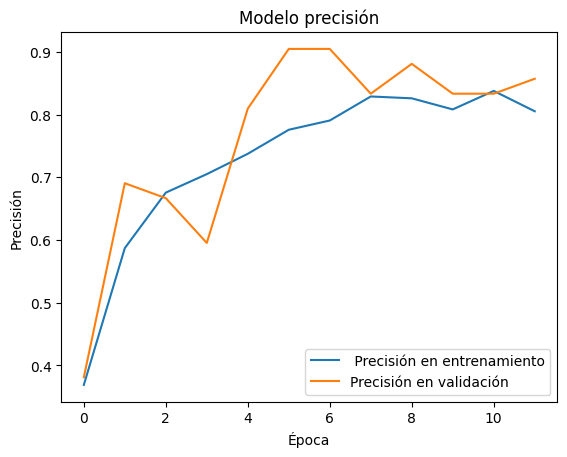

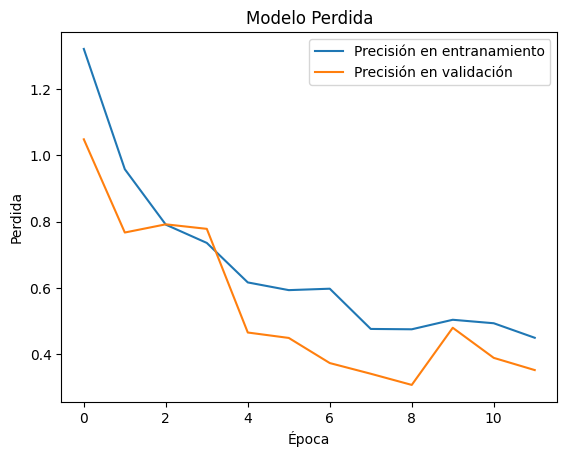

In [116]:
#Representamos gráficamente la precisión del modelo en cada época para el conjunto de entrenamiento y validación.
plt.plot(history.history['accuracy'], label=' Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Modelo precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Gráfica de pérdida
plt.plot(history.history['loss'], label='Precisión en entranamiento')
plt.plot(history.history['val_loss'], label='Precisión en validación')
plt.title('Modelo Perdida')
plt.xlabel('Época')
plt.ylabel('Perdida')
plt.legend()
plt.show()


En estos gráficos nos dice que hay una **buena reducción de pérdida** y una **mejora de precisión** tanto en los datos de entrenamiento como de validación.  
La ausencia de un gran gap entre las métricas de entrenamiento y validación confirma que el **modelo generaliza bien** y **no tenemos signos que indiquen que se sobreajusta**.  
Este comportamiento nos indica que el diseño de este modelo de CNNs (arquitectura y la regularización) **es apropiado para la clasificación** de radiografías.

## Creación y entrenamiento modelo básico para compararlo:

Aqui vamos a definir la arquitectura y a entrenar a nuestro **modelo basico**, que hemos diseñado a proposito para que funcione peor que el otro añadiendole menos capas y sin regularizaciones

In [118]:


# Modelo más simple para comparar
def create_simple_model():
    model = Sequential([
        # Primera y única capa convolucional
        Conv2D(8, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        Flatten(),  # Aplanar después de una sola capa convolucional
        Dense(16, activation='relu'),  # Capa densa muy pequeña
        Dense(3, activation='softmax')  # Capa de salida
    ])

    # Compilar el modelo
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Crear el modelo "peor"
simple_model = create_simple_model()

# Mostrar el resumen del modelo
simple_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)                   │ (None, 222, 222, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 394272)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 16)                  │       6,308,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,308,643 (24.07 MB)

 Trainable params: 6,308,643 (24.07 MB)

 Non-trainable params: 0 (0.00 B)

El entrenamiento sigue el mismo flujo, pero sin Data Augmentation para limitar aún más su capacidad de generalización, aparte de que tiene menos capas convolucionales(solo 1) y tampoco tiene la regularización dropout que mejora la capacidad de generalización de las redes neuronales al prevenir el sobreajuste.

In [120]:
early_stopping1 = EarlyStopping(
    monitor='val_loss',  # Monitorea la pérdida en validación
    patience=4,          # Si la pérdida no mejora después de 4 épocas consecutivas, el entrenamiento se detendrá.
    restore_best_weights=True,  #Una vez detenido el entrenamiento, se restauran los pesos del modelo con el mejor desempeño en validación.
    verbose=1
)

# Entrenar el modelo simple (sin Data Augmentation)
history_simple = simple_model.fit(
    train_images, train_labels,  # Sin Data Augmentation
    validation_data=(val_images, val_labels),  # Validación estándar
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping1]  # Usamos EarlyStopping para detener el sobreentrenamiento
)


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 448ms/step - accuracy: 0.4358 - loss: 1.0077 - val_accuracy: 0.5000 - val_loss: 0.9513
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 450ms/step - accuracy: 0.5755 - loss: 0.8839 - val_accuracy: 0.6190 - val_loss: 0.7839
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 637ms/step - accuracy: 0.6300 - loss: 0.7570 - val_accuracy: 0.5952 - val_loss: 0.8438
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 426ms/step - accuracy: 0.4910 - loss: 0.9407 - val_accuracy: 0.5952 - val_loss: 0.8181
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 553ms/step - accuracy: 0.6078 - loss: 0.8370 - val_accuracy: 0.5952 - val_loss: 0.8029
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 437ms/step - accuracy: 0.6242 - loss: 0.8354 - val_accuracy: 0.6190 - val_loss: 0.7941
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 2.


**Early stopping** ha parado en la época 6, pero nos indica que su mejor época es la 2, ha continuado debido a que tenemos **patience=4** y entonces ha ido ejecutandose y ha visto que no mejoraba en las siguiente 4 épocas.

## *Interfaz de usuario*

Podemos crear una interfaz gráfica sencilla utilizando Gradio, una librería ideal para este tipo de aplicaciones en Python. Permite crear interfaces donde el usuario puede cargar imágenes y recibir resultados de clasificación junto con las probabilidades asociadas.

In [123]:
pip install gradio


In [124]:


#Parámetros
IMG_SIZE = 224  #tamaño de las imágenes esperado por el modelo
classes = ["Healthy", "Covid-19", "Pneumonia"]  #clases de salida

#función para predecir con porcentajes
def predict(image):
    """
    Procesa la imagen de entrada, realiza la predicción y devuelve la clase predicha junto con los porcentajes.
    """
    try:
        #Redimensionar la imagen al tamaño esperado
        image = image.resize((IMG_SIZE, IMG_SIZE))
        #Convertir la imagen en array y normalizar
        image_array = img_to_array(image) / 255.0
        #añadir una dimensión para el batch
        image_array = np.expand_dims(image_array, axis=0)

        #realizar predicción con el modelo
        predictions = model.predict(image_array)[0]  # Obtener las probabilidades
        predicted_class = classes[np.argmax(predictions)]  # Clase con mayor probabilidad

        #formatear las probabilidades en un mensaje
        probabilities = [f"{cls}: {prob * 100:.2f}%" for cls, prob in zip(classes, predictions)]
        result_message = f"Predicción: {predicted_class}\n\nPorcentajes precisión:\n" + "\n".join(probabilities)

        return result_message  # Retornar predicción y porcentajes
    except Exception as e:
        return "Error al procesar la imagen."

# Crear la interfaz con Gradio
interface = gr.Interface(
    fn=predict,  # Función de predicción
    inputs=gr.Image(type="pil"),  # Entrada: Imagen cargada por el usuario
    outputs="text",  # Salida: Texto con la clase predicha y porcentajes
    title="Clasificador de Radiografías (COVID-19)",
    description="Sube una radiografía para clasificarla como Healthy, Covid-19 o Pneumonia. "
                "La interfaz muestra la categoría predicha y los porcentajes asociados a cada clase."
)

# Lanzar la interfaz
interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://81aa189fec7dfb5226.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


**A continuación tienes una captura de la interfaz en funcionamiento por si a la hora de ejecutar da problemas**

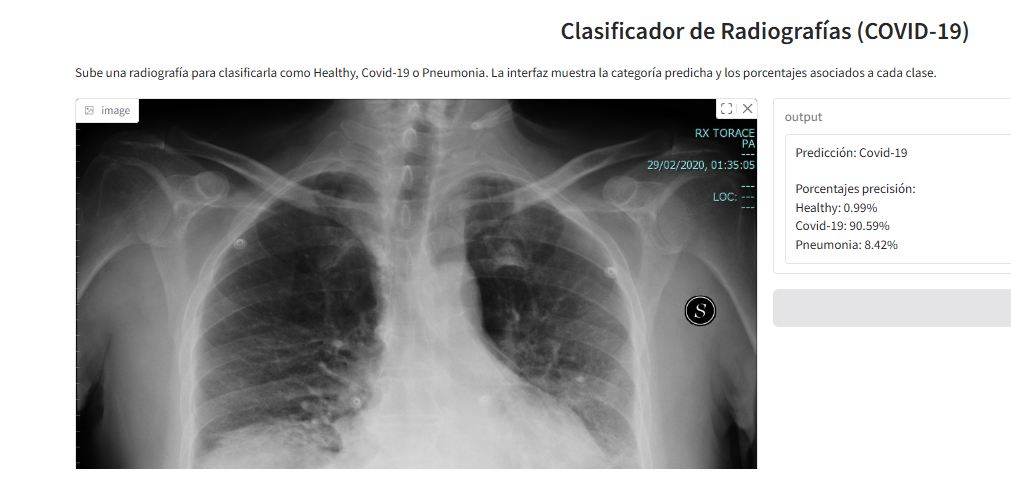

**Versión para hacerlo manualmente sin necesidad de interfaz predefinida**

Hemos metido el link de una imágen de covid

In [131]:
from PIL import Image

# Cargar una imagen manualmente
test_image_path = '/content/extubation-4.jpg'  # Ruta de tu imagen de prueba
image = Image.open(test_image_path)

# Procesar la imagen con la función predict
resultado = predict(image)
print("Resultado de predicción:", resultado)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Resultado de predicción: Predicción: Covid-19

Porcentajes precisión:
Healthy: 4.60%
Covid-19: 93.21%
Pneumonia: 2.20%


# Resultados y Conclusiones

En esta sección se debe implementar la fase de test de los mejores modelos desarrollados anteriormente.

Se valorarán aspectos como:
- Razonamiento de qué arquitectura es la más adecuada
- Análisis cuantitativo y cualitativo de los resultados.

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step - accuracy: 0.8590 - loss: 0.3011
Pérdida en prueba: 0.2947
Precisión en prueba: 0.8667
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 445ms/step


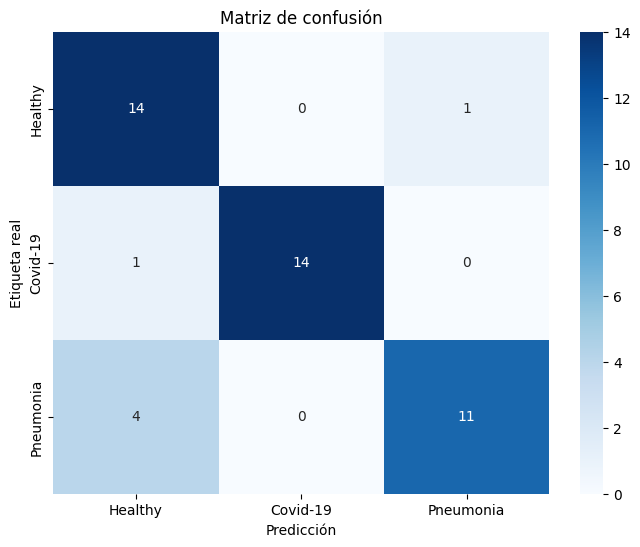


Informe de la clasificación:
              precision    recall  f1-score   support

     Healthy       0.74      0.93      0.82        15
    Covid-19       1.00      0.93      0.97        15
   Pneumonia       0.92      0.73      0.81        15

    accuracy                           0.87        45
   macro avg       0.88      0.87      0.87        45
weighted avg       0.88      0.87      0.87        45



In [117]:
#Evaluamos el desempeño del modelo en los datos de prueba, obteniendo la pérdida y la precisión.
test_loss, test_accuracy = model.evaluate(test_images, test_labels, batch_size=BATCH_SIZE)
print(f"Pérdida en prueba: {test_loss:.4f}")# Mostramos la pérdida final en el conjunto de prueba
print(f"Precisión en prueba: {test_accuracy:.4f}")  # Mostramos la precisión final en el conjunto de prueba


# Usamos el modelo para realizar predicciones en las imágenes del conjunto de prueba.
predictions = model.predict(test_images)

#Transformamos las etiquetas reales y las predicciones de formato one-hot a formato categórico (0, 1, 2).
y_true = np.argmax(test_labels, axis=1)
y_pred = np.argmax(predictions, axis=1)

# Crear matriz de confusión, que muestra cómo se distribuyen las predicciones correctas e incorrectas por clase.
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Covid-19", "Pneumonia"], yticklabels=["Healthy", "Covid-19", "Pneumonia"]) # Heatmap para visualizar la matriz de confusión
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de confusión")
plt.show()

#Informe detallado con métricas como precisión, sensibilidad y F1-score para cada clase.
print("\nInforme de la clasificación:")
print(classification_report(y_true, y_pred, target_names=["Healthy", "Covid-19", "Pneumonia"]))


La matriz de confusión muestra que el modelo clasifica bien las imágenes de **Healthy** (14 correctas, 1 error) y **Covid-19** (14 correctas, 1 error). Sin embargo, tiene más problemas con la clase **Pneumonia**, clasificando 4 imágenes incorrectamente como **Healthy** y logrando 11 aciertos.

En general, el modelo tiene buen rendimiento, especialmente en **Healthy** y **Covid-19**, pero necesita mejorar en la diferenciación entre **Pneumonia** y **Healthy**.

Aqui vemos el test de nuestro modelo inicial que es el que hemos decidido quedarnos y como podemos observar clasifica las imagenes de test muy bien, lo que nos dice que no se ha 'aprendido' las imagenes de nuestros datasets simplemente, sino que acierta con imagenes de otra procedencia

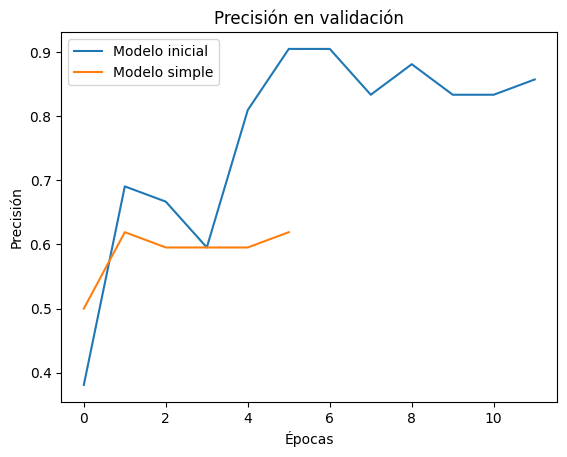

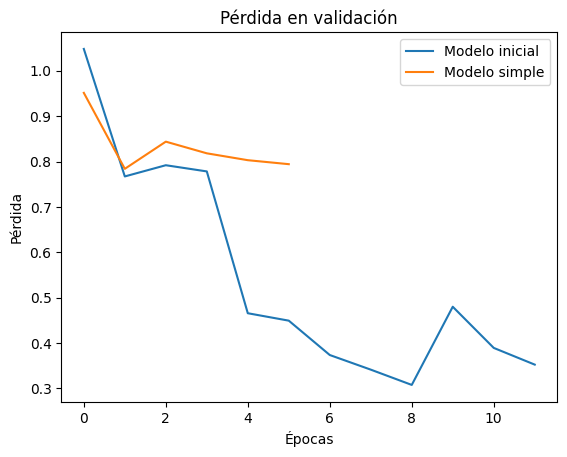

In [121]:
# Comparar precisión
plt.plot(history.history['val_accuracy'], label='Modelo inicial')
plt.plot(history_simple.history['val_accuracy'], label='Modelo simple')
plt.title('Precisión en validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Comparar pérdida
plt.plot(history.history['val_loss'], label='Modelo inicial')
plt.plot(history_simple.history['val_loss'], label='Modelo simple')
plt.title('Pérdida en validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


**Velocidad de aprendizaje:** El modelo inicial aprende más rápidamente y alcanza un rendimiento mucho más alto en pocas épocas.

**Estabilidad:** El modelo inicial mantiene una precisión alta y relativamente constante después de algunas fluctuaciones. Por otro lado, el modelo simple parece estancarse sin alcanzar niveles competitivos.

**Diferencia de rendimiento:** Al final de las épocas, el modelo inicial tiene una precisión de validación significativamente superior al modelo simple.

In [122]:
# Evaluar modelo inicial
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Modelo inicial - Pérdida: {test_loss:.4f}, Precisión: {test_accuracy:.4f}")

# Evaluar modelo simple
test_loss_simple, test_accuracy_simple = simple_model.evaluate(test_images, test_labels)
print(f"Modelo simple - Pérdida: {test_loss_simple:.4f}, Precisión: {test_accuracy_simple:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 585ms/step - accuracy: 0.8590 - loss: 0.3011
Modelo inicial - Pérdida: 0.2947, Precisión: 0.8667
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.7317 - loss: 0.9453
Modelo simple - Pérdida: 1.0144, Precisión: 0.6444


Viendo los resultados podemos ver que el modelo inicial es mejor, ya que su precisión es mayor y su pérdida menor, a parte, vemos que el early stopping ha hecho su trabajo en el modelo simple, ya que ha detenido el entrenamiento cuando llevaba 4 epocas sin aprender mas.

### **Diferencias estructurales del Modelo Inicial frente al Modelo Básico**

#### **1. Número y Profundidad de Capas Convolucionales**
- **Modelo inicial:**
  - Tres capas convolucionales con **32, 64 y 128 filtros**, lo que permite capturar características jerárquicas (desde bordes simples hasta patrones complejos).
  - El incremento progresivo de filtros ayuda a captar información específica y detallada en las imágenes.
- **Modelo simple:**
  - Solo una capa convolucional con **8 filtros**, que es insuficiente para capturar patrones complejos presentes en las radiografías.

**Ventaja:** El modelo inicial tiene mayor capacidad para extraer características relevantes de las imágenes médicas, lo cual es crucial para detectar anomalías sutiles.

---

#### **2. Operaciones de MaxPooling**
- **Modelo inicial:**
  - Cada capa convolucional se combina con una operación de **MaxPooling** (2x2), reduciendo la dimensionalidad y concentrando información relevante.
- **Modelo simple:**
  - No incluye MaxPooling, lo que aumenta la cantidad de información irrelevante que llega a la capa densa.

**Ventaja:** El uso de MaxPooling en el modelo inicial mejora la eficiencia computacional y ayuda a retener las características más importantes.

---

#### **3. Regularización**
- **Modelo inicial:**
  - Incluye **Dropout** (tasa 0.5) para prevenir sobreajuste, algo esencial en datasets médicos limitados.
- **Modelo simple:**
  - No incorpora ningún mecanismo de regularización, lo que lo hace más propenso a sobreajustarse a los datos de entrenamiento.

**Ventaja:** El modelo inicial está mejor preparado para generalizar a nuevos datos, reduciendo el riesgo de sobreajuste.

---

#### **4. Arquitectura Compleja vs. Simple**
- **Modelo inicial:**
  - Aplana las características después de tres capas convolucionales y combina estas características mediante una capa densa con **128 neuronas**, optimizando la clasificación.
- **Modelo simple:**
  - Aplana las características después de una sola capa convolucional y las combina con una capa densa de solo **16 neuronas**, lo que limita su capacidad para representar patrones complejos.

**Ventaja:** La mayor capacidad de las capas densas en el modelo inicial permite una mejor representación de las características y una clasificación más precisa.

---

#### **5. Ajuste a la Tarea de Clasificación de Radiografías**
- **Modelo inicial:**
  - Diseñado para extraer características detalladas y generalizar mejor en un problema de clasificación multiclase (tres clases).
- **Modelo simple:**
  - Arquitectura demasiado simple, diseñada para problemas más básicos, no puede manejar la complejidad de las radiografías médicas.

**Ventaja:** El modelo inicial está mejor ajustado a la naturaleza compleja del problema.

---
---

### **Resumen de las Ventajas del Modelo Inicial**
1. **Mayor capacidad de extracción de características:** Gracias a múltiples capas convolucionales con filtros progresivos.
2. **Eficiencia computacional:** Uso de MaxPooling para reducir dimensionalidad.
3. **Generalización robusta:** Incorporación de Dropout para evitar sobreajuste.
4. **Representación más rica:** Arquitectura densa que permite una clasificación más precisa.
5. **Adecuación a datos médicos:** Su diseño jerárquico capta mejor los patrones complejos presentes en las radiografías.



Por lo tanto el **modelo inicial** es mucho más adecuado para tareas complejas como la clasificación de radiografías, y tiene más precisión debido a sus técnicas implementadas.

# *Explainability*

Investiga sobre las técnicas que se utilizan para entender las decisiones de una CNN. Por ejemplo, los [Class Activation Maps](https://arxiv.org/pdf/1512.04150.pdf) (CAM)[4] son una modificación en la arquitectura de una CNN de clasificación de imágenes que permite visualizar qué partes de la imagen se consideran para la clasificación de una muestra con una determinada etiqueta. Variaciones de las CAMs se han aplicado recientemente para entender el comportamiento de las redes para detectar Covid-19 [8].

Otro método es el popular [Deep Dream](https://deepdreamgenerator.com/)[11]. Este método, a parte de generar imágenes con un estilo artístico/psicodélico, sirve para entender el tipo de características que busca una red en la imagen de entrada para clasificarla con una determinada etiqueta.

Implementa alguna técnica de visualización.